In [20]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from learned import *

np.random.seed(0)

# Transform Settings
Double check whether jitter and normalization has already been applied, reduce num_images or n_bootstrap if taking too long

In [21]:
DATASET = "pastis"
RAW_DATA_SUFFIX = "full-pastis-RGB-jitter"
FINAL_DATA_NAME = 'pastis-full' 
CONSTANT_SAMPLE_SIZE = int(1e5)

num_images=None
jitter=False 
normalize=False 
n_bootstrap=1000

data_dir = os.path.join(ROOT_DIR, 'raw-data', DATASET, RAW_DATA_SUFFIX)

In [22]:
filter_groups = {
    "single_edge": [3, 6, 10, 11, 12, 13, 14, 23, 24, 28, 29, 30, 32, 34, 43, 48, 49, 50, 55, 57], # gabor-like / edge detector
    "multi_edge": [9, 16, 18, 22, 25, 27, 33, 41, 54, 63], #complex gabor / complex edge detector
    "eye": [21, 31, 37, 39, 45, 46,], # color contrast
    "dual_color": [0, 2, 4, 5, 17, 20, 26, 38, 42, 44, 47, 56, 59], # color contrast
    "inside_out": [7, 15, 19, 35, 40, 51, 52, 53, 58], # smoothing
    "misc": [1, 8, 36, 60, 61, 62] # misc
}

# Load and Transform

In [23]:
images = load_images_from_directory(data_dir, n=num_images, jitter=jitter, normalize=normalize)
print("num_images, H, W, channels:", images.shape, "\nnum_filters, H, W, channels:", filters.shape)

Loading images:   0%|          | 0/1590 [00:00<?, ?it/s]

num_images, H, W, channels: (1590, 128, 128, 3) 
num_filters, H, W, channels: (64, 11, 11, 3)


In [24]:
filter_data_map = dict()

for i in tqdm(range(len(filters))):
    
    fil = filters[i]
    transformed = []
    for j, image in enumerate(images):
        convolved = convolve(image, fil, mode='same')
        transformed.append(convolved.flatten())

    transformed = np.hstack(transformed)
    transformed = np.sort(transformed)[np.round(np.linspace(0, transformed.size - 1, min(transformed.size, CONSTANT_SAMPLE_SIZE))).astype(int)]
    filter_data_map[i] = transformed

filter_data_map[0]

  0%|          | 0/64 [00:00<?, ?it/s]

array([-70.79580902, -54.0053194 , -51.21679648, ...,  54.41175113,
        57.78687548,  76.51266746])

# Skewness

In [ ]:
filters_df = pd.DataFrame(columns=['filter_idx', 'skew', 'skew_ci_low', 'skew_ci_high', 'filter_group']).set_index('filter_idx')
for filter_idx, data in filter_data_map.items():
    skew_ci = bootstrap((data,), skew, confidence_level=0.95, n_resamples=n_bootstrap, method='percentile').confidence_interval
    filters_df.loc[filter_idx] = {
        'skew': skew(data),
        'skew_ci_low': skew_ci.low,
        'skew_ci_high': skew_ci.high,
    }
    
filters_df['nonskewed'] = (filters_df['skew_ci_low'] <= 0) & (filters_df['skew_ci_high'] >= 0)
filters_df = filters_df.round(2).astype(float)
filters_df['filter_group'] = [filter_group_map[i] for i in filters_df.index]
filters_df.to_csv(os.path.join(ROOT_DIR, 'dataset-preparation', DATASET, f"{FINAL_DATA_NAME}_skewness_df.csv"))
filters_df.head()


In [ ]:
nonskewed_filter_idxs = list(filters_df[filters_df['nonskewed'] == True].index)

nonskewed_filter_idxs[:5]

[2,
 3,
 4,
 5,
 6,
 9,
 10,
 11,
 12,
 13,
 16,
 17,
 18,
 20,
 22,
 24,
 25,
 27,
 30,
 33,
 34,
 38,
 41,
 42,
 44,
 47,
 48,
 49,
 50,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 63]

In [ ]:
nonskewed_df = pd.read_csv(os.path.join(ROOT_DIR, 'learned-filters', 'nonskewed_filter_idxs_df.csv')).set_index(['dataset', 'num_images', 'num_bootstrap'])
new_row = {'dataset': FINAL_DATA_NAME, 'num_images': num_images, 'num_bootstrap': n_bootstrap, 'nonskewed_filter_idxs': nonskewed_filter_idxs}
nonskewed_df.loc[FINAL_DATA_NAME, num_images if num_images is not None else len(images), n_bootstrap] = new_row
nonskewed_df.to_csv(os.path.join(ROOT_DIR, 'learned-filters', 'nonskewed_filter_idxs_df.csv'))
nonskewed_df

nonskewed_filter_idxs
dataset     num_images num_bootstrap                                                   
coco-indoor 100        1000           Index([ 0,  4,  5,  6,  8,  9, 11, 12, 16, 18,...
pastis-full 10         10             [2, 3, 4, 9, 10, 12, 13, 16, 18, 20, 22, 33, 4...
            1590       1000           [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18,...

In [ ]:
filter_group_df = filters_df.groupby('filter_group')[['nonskewed']].sum()
totals = filters_df.groupby('filter_group')[['nonskewed']].size()
filter_group_df['%_nonskewed'] = filter_group_df['nonskewed'] / totals
filter_group_df

,nonskewed,%_nonskewed
filter_group,,
dual_color,11.0,0.846154
eye,0.0,0.000000
inside_out,0.0,0.000000
misc,3.0,0.500000
multi_edge,10.0,1.000000
single_edge,14.0,0.700000


# Visualize Transformed Data

In [ ]:
filter_group_colors = {'single_edge': 'red',
                        'multi_edge': 'blue',
                        'eye': 'green',
                        'dual_color': 'yellow',
                        'inside_out': 'purple',
                        'misc': 'orange'}

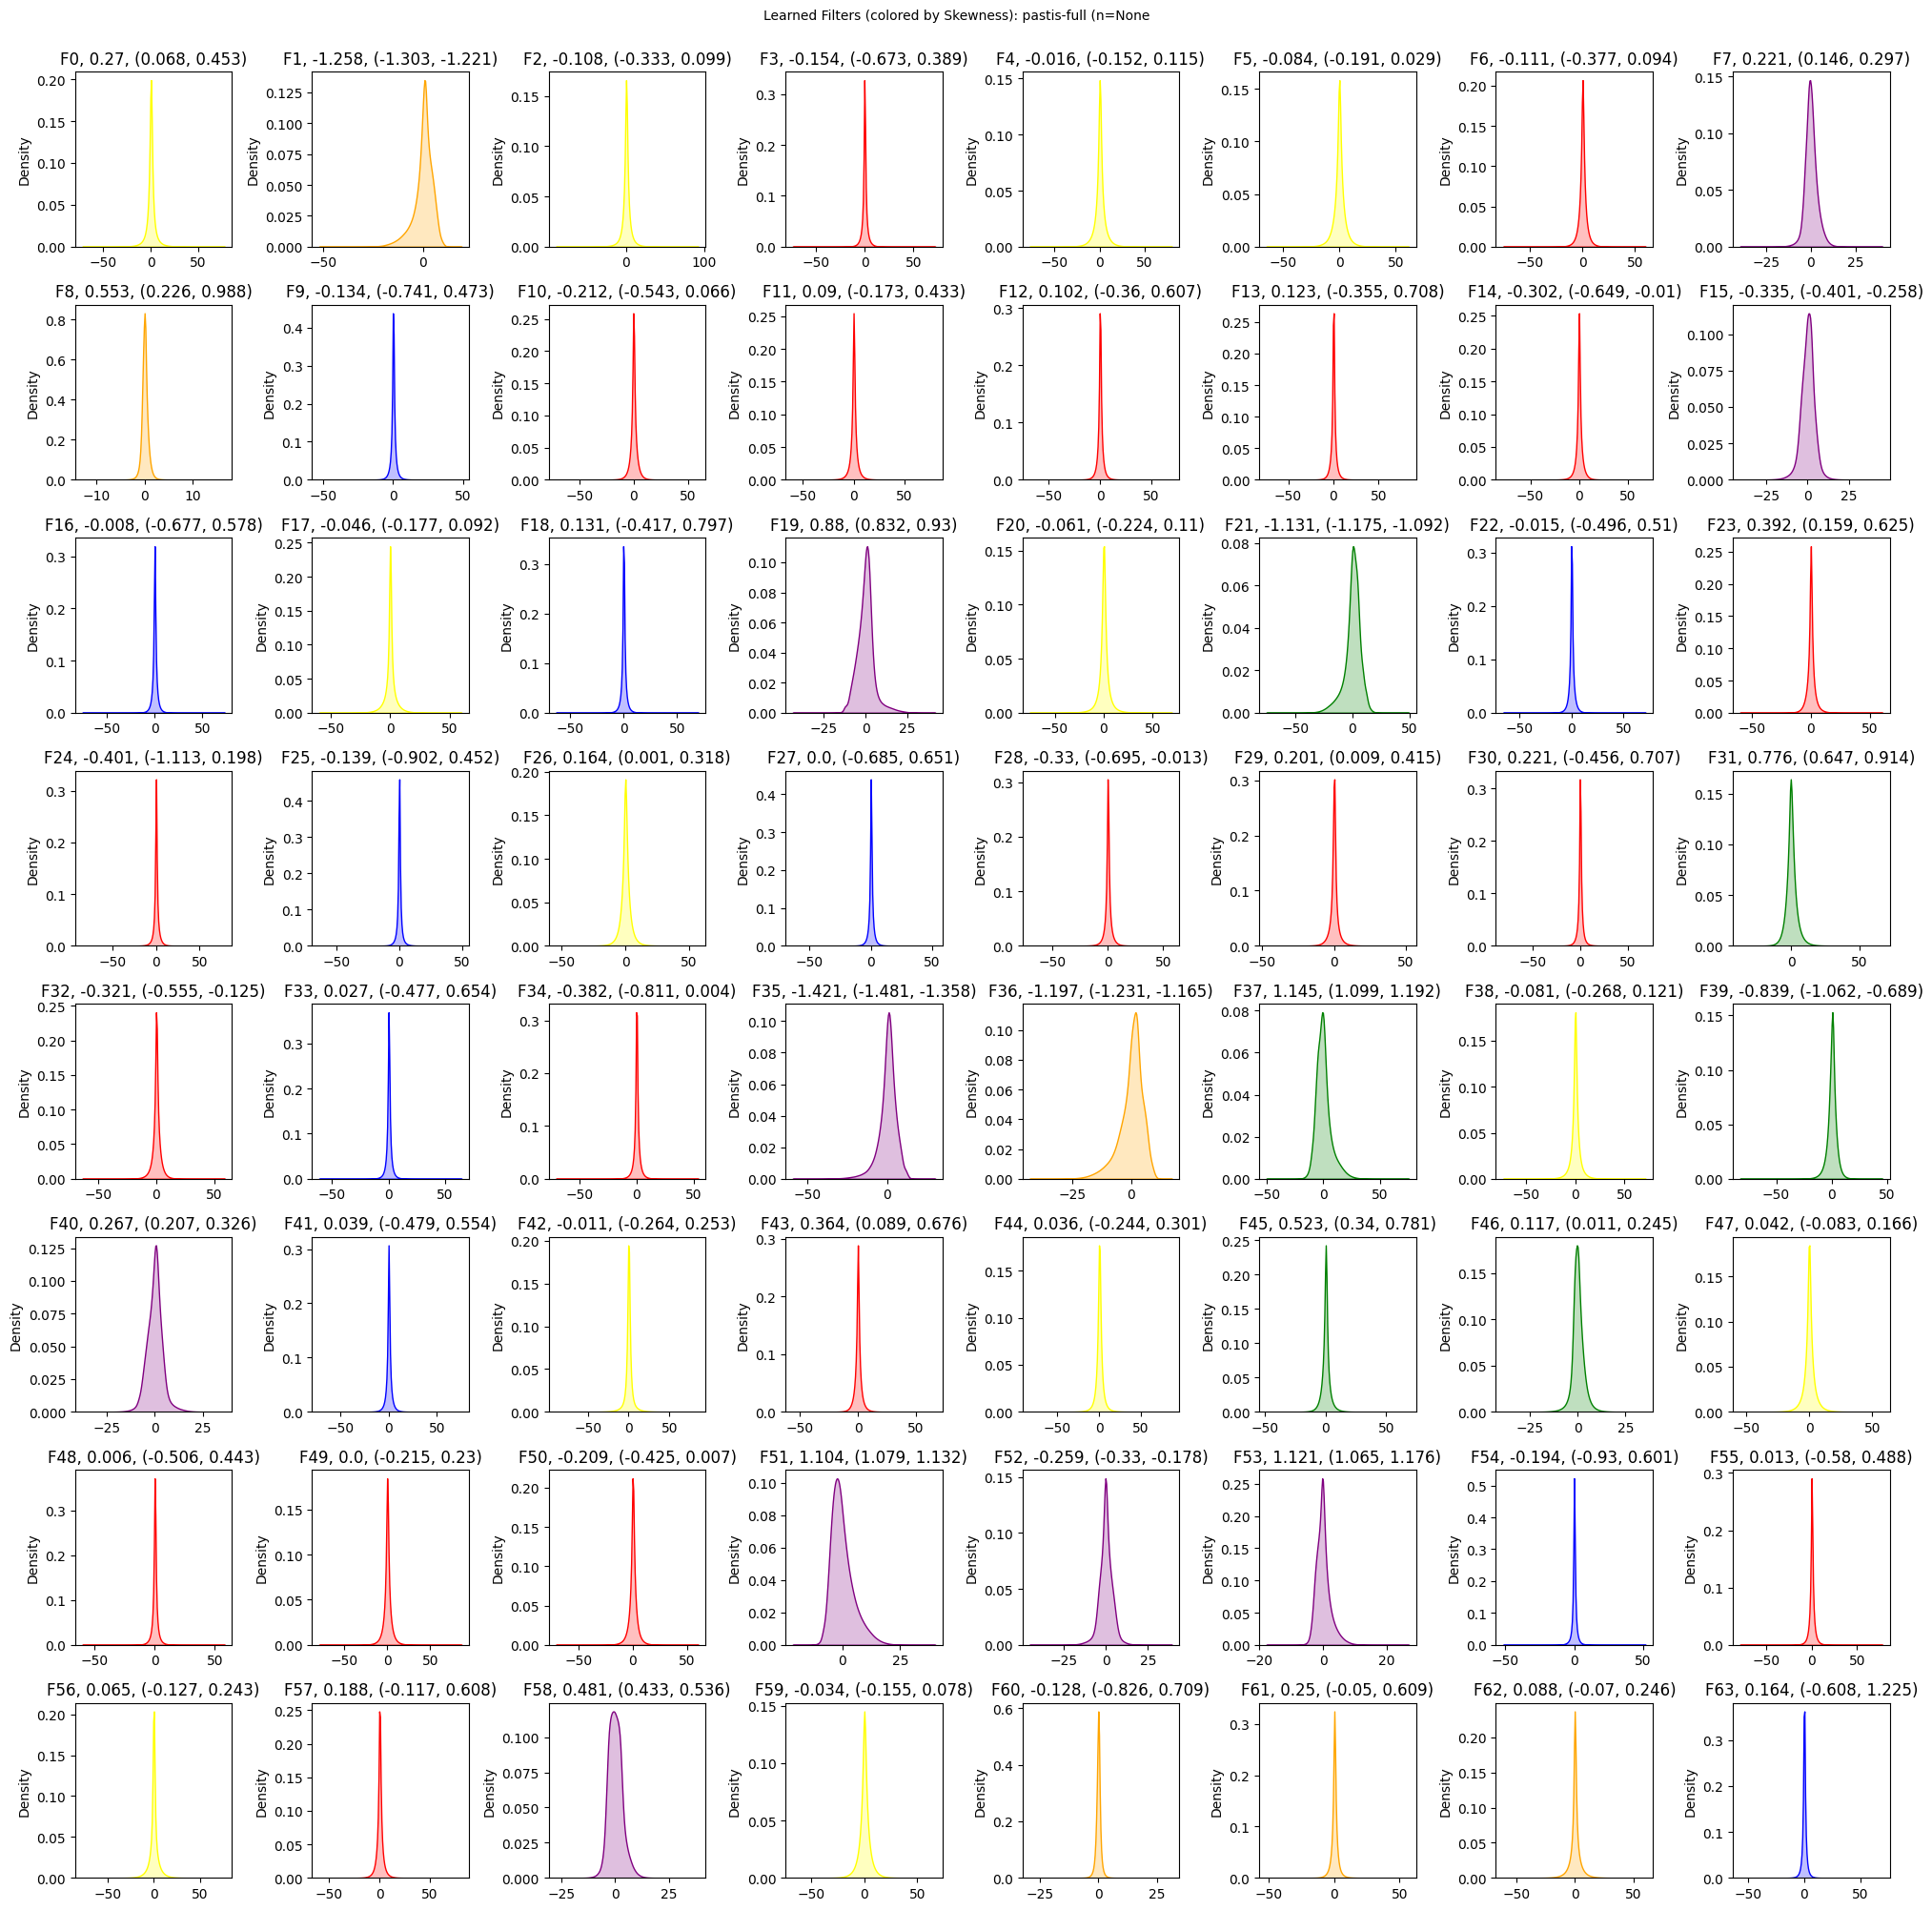

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))
axes = axes.flatten()
fig.suptitle(f"Learned Filters (colored by Skewness): {FINAL_DATA_NAME} (n={num_images}", y=1, fontsize=20)
for i, (filter_idx, data) in enumerate(filter_data_map.items()):
    filter_group = filter_group_map[i]
    color = filter_group_colors[filter_group]
    sns.kdeplot(data, ax=axes[i], fill=True, color=color)
    axes[i].set_title(f"F{filter_idx}, {filters_df.loc[i, 'skew']}, {filters_df.loc[i, 'skew_ci_low'], filters_df.loc[i, 'skew_ci_high']}")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

plt.savefig(os.path.join(ROOT_DIR, 'dataset-preparation', DATASET, f"{FINAL_DATA_NAME}_filter_group.jpg"))

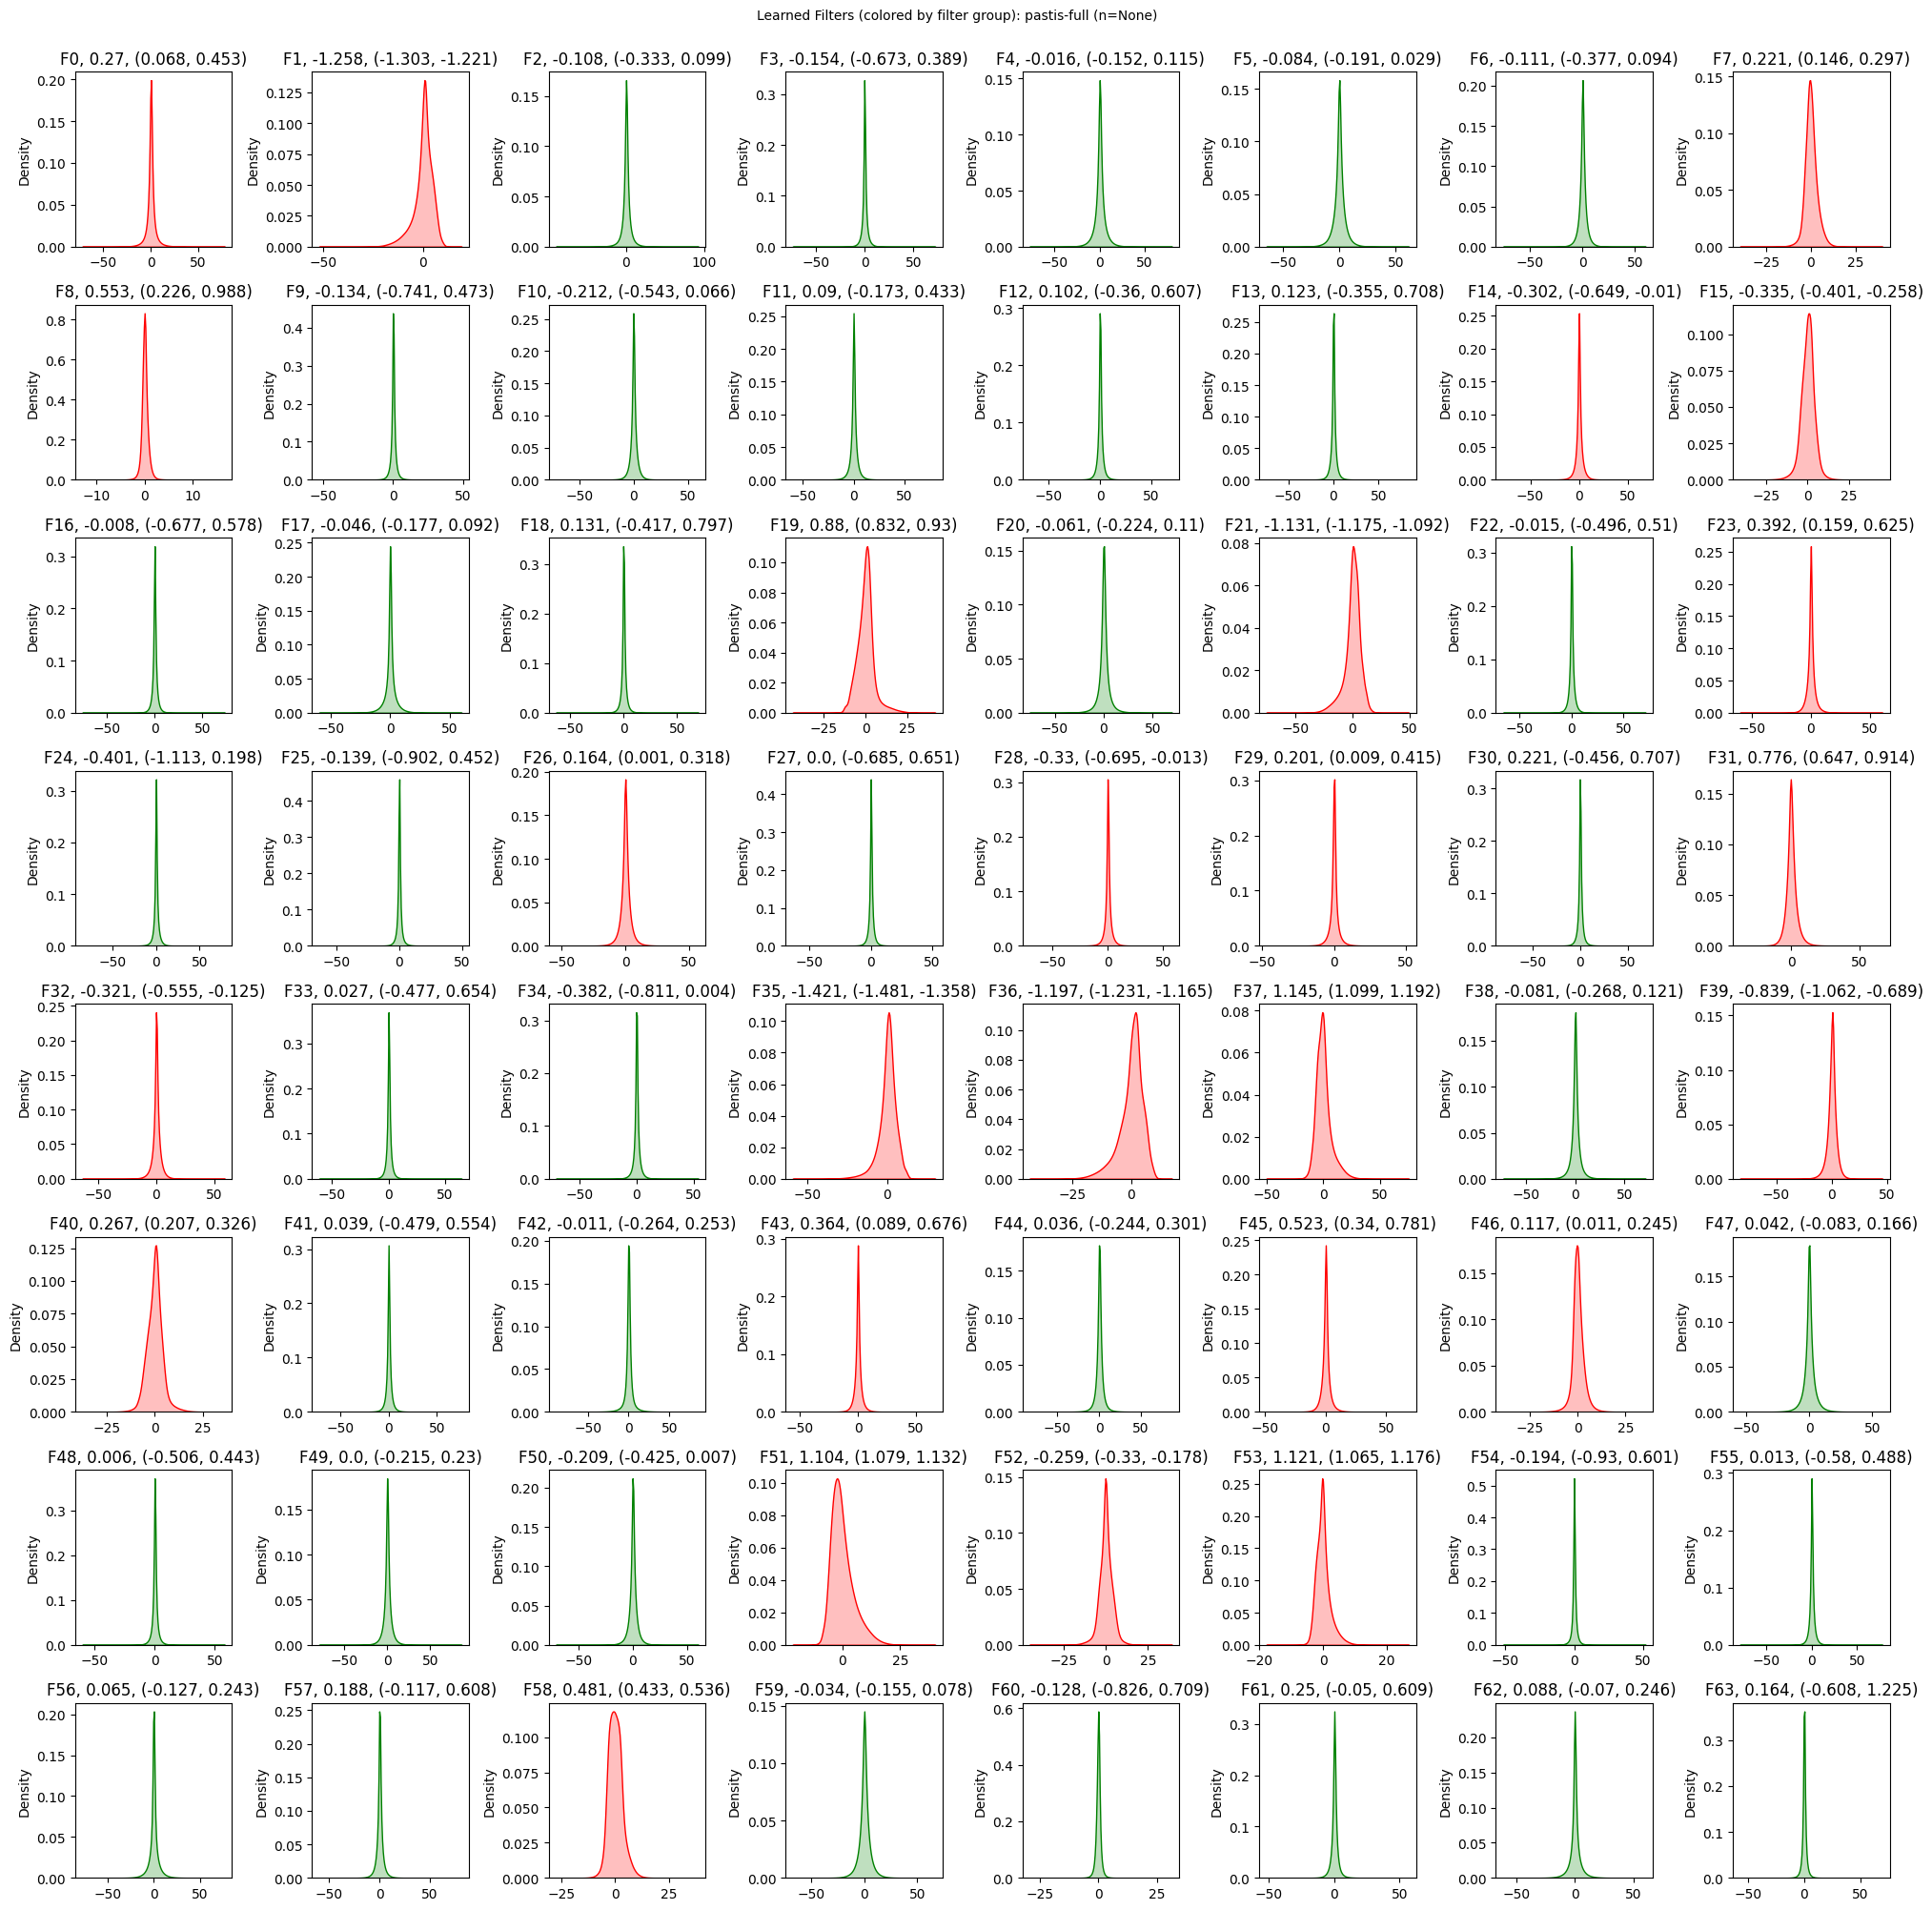

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))
axes = axes.flatten()
fig.suptitle(f"Learned Filters (colored by filter group): {FINAL_DATA_NAME} (n={num_images})", y=1, fontsize=20)
for i, (filter_idx, data) in enumerate(filter_data_map.items()):
    filter_group = filter_group_map[i]
    color = 'green' if filters_df.loc[i, 'nonskewed'] else 'red'
    sns.kdeplot(data, ax=axes[i], fill=True, color=color)
    axes[i].set_title(f"F{filter_idx}, {filters_df.loc[i, 'skew']}, {filters_df.loc[i, 'skew_ci_low'], filters_df.loc[i, 'skew_ci_high']}")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

plt.savefig(os.path.join(ROOT_DIR, 'dataset-preparation', DATASET, f"{FINAL_DATA_NAME}_filter_skewness.jpg"))

In [ ]:
nonskewed_filter_idxs = list(filters_df[filters_df['nonskewed'] == True].index)
print(len(nonskewed_filter_idxs))
nonskewed_filter_idxs[:5]

[2,
 3,
 4,
 5,
 6,
 9,
 10,
 11,
 12,
 13,
 16,
 17,
 18,
 20,
 22,
 24,
 25,
 27,
 30,
 33,
 34,
 38,
 41,
 42,
 44,
 47,
 48,
 49,
 50,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 63]

In [ ]:
nonskewed_df = pd.read_csv(os.path.join(ROOT_DIR, 'learned-filters', 'nonskewed_filter_idxs_df.csv')).set_index(['dataset', 'num_images', 'num_bootstrap'])
new_row = {'dataset': FINAL_DATA_NAME, 'num_images': num_images, 'num_bootstrap': n_bootstrap, 'nonskewed_filter_idxs': nonskewed_filter_idxs}
nonskewed_df.loc[FINAL_DATA_NAME, num_images if num_images is not None else len(images), n_bootstrap] = new_row
nonskewed_df.to_csv(os.path.join(ROOT_DIR, 'learned-filters', 'nonskewed_filter_idxs_df.csv'))
nonskewed_df

nonskewed_filter_idxs
dataset     num_images num_bootstrap                                                   
coco-indoor 100        1000           Index([ 0,  4,  5,  6,  8,  9, 11, 12, 16, 18,...
pastis-full 10         10             [2, 3, 4, 9, 10, 12, 13, 16, 18, 20, 22, 33, 4...
            1590       1000           [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18,...

# Save Data

In [ ]:
data_output_file = os.path.join(ROOT_DIR, 'transformed-data', f"{FINAL_DATA_NAME}-learned.pickle") 
size_output_file = os.path.join(ROOT_DIR, 'transformed-data', f"{FINAL_DATA_NAME}-learned-size.pickle")

total_samples = np.prod(images.shape)
print("Without subsampling size:", total_samples)
pd.to_pickle(filter_data_map, data_output_file)
pd.to_pickle({i : total_samples for i in range(len(filter_data_map))}, size_output_file)

Without subsampling size: 78151680
